# **Task 4.** 

Authored by:
* **Arina Shinkorenok**
* **Nikita Matveev**
* **Fyodor Prazdnikov**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares, differential_evolution
import random
import networkx as nx



In [2]:
def f(x):
    return 1/(x**2 - 3*x + 2)

def approximator(x, a, b, c, d):
    return (a*x + b)/(x**2 + c*x + d)

approximator_v = np.vectorize(approximator, excluded=['a', 'b', 'c', 'd'])

def compute_residuals(x, y, params):
    a, b, c, d = params
    y_hat = approximator_v(x, a, b, c, d)
    errors = (y_hat - y) 
    return errors
    
def udf_least_squares(x, y, params):
    a, b, c, d = params
    y_hat = approximator_v(x, a, b, c, d)
    errors = (y_hat - y) ** 2
    return np.sum(errors)

def plot_results(x, y, 
                 result_x, 
                 method,
                 nit=None,
                 nfev=None,
                 fun=None):
    y_hat = approximator_v(x, *result_x)

    plt.scatter(x, y, color='b', s=1.5)
    plt.plot(x, y_hat, color='r')
    plt.title(f'Least squares optimisation by {method}')

    if nit:
        plt.figtext(1, .8, f"Num iterations: {nit}")
    if nfev:
        plt.figtext(1, .75, f"Function evaluations: {nfev}")
    if fun:
        plt.figtext(1, .7, f"MSE: {fun/len(x):.2f}:")
    

def plot_comparison(x, y, methods):
    plt.figure(figsize=(12, 12))
    colors = ['magenta', 'b', 'green', 'orange']
    plt.scatter(x, y, color='lightblue', s=1, alpha=0.7)  # You can adjust 's' to control the point size
    
    line_styles = ['-', '--', '-.', ':']
    
    for i, (k, v) in enumerate(methods.items()):
        y_hat = approximator_v(x, *v)
        
        # Choose a line style from the list based on the index 'i'
        line_style = line_styles[i % len(line_styles)]
        
        # Plot the data with the selected line style and color
        plt.plot(x, y_hat, color=colors[i], label=k)
    
    plt.legend()
    plt.title('Comparison of Different Methods')




Constants

In [3]:
EPS = 0.001
MAX_ITER = 1000

### Generating data

In [4]:
x_generated = []
y_generated = []

for k in range(0, 1001):
    x_k = k*(3/1000)
    d_k = np.random.normal(0, 1)
    f_k = f(x_k)

    x_generated.append(x_k)
    if f_k < - 100:
        y_k = -100 + d_k
    elif (f_k >= -100) and (f_k <= 100):
        y_k = f_k + d_k
    else:
        y_k = 100 + d_k
    y_generated.append(y_k)

    least_squares_fixed = lambda params: udf_least_squares(x_generated, y_generated, params)
    plot_results_fixed = lambda result_x, method, nit, nfev, fun: plot_results(x_generated, y_generated, result_x, method, nit, nfev, fun)
    compute_residuals_fixed = lambda params: compute_residuals(x_generated, y_generated, params)
    plot_comparision_fixed = lambda methods: plot_comparison(x_generated, y_generated, methods)

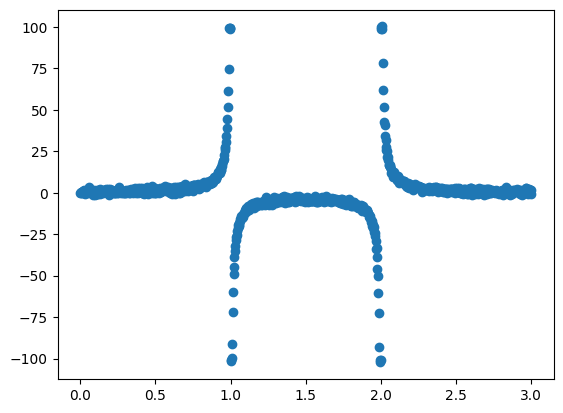

In [5]:
plt.scatter(x_generated, y_generated)

### Nelder-mead 

In [6]:
nel_mead_res = minimize(fun=least_squares_fixed, x0=(0,0,0,0), method='Nelder-Mead', tol=EPS)

C:\Users\matni\AppData\Local\Temp\ipykernel_4792\2939550266.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return (a*x + b)/(x**2 + c*x + d)
C:\Users\matni\AppData\Local\Temp\ipykernel_4792\2939550266.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (a*x + b)/(x**2 + c*x + d)


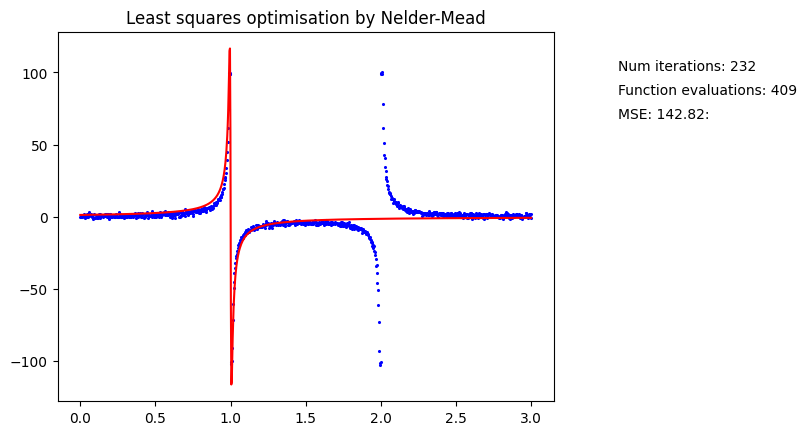

In [7]:
plot_results_fixed(nel_mead_res.x, 'Nelder-Mead', nel_mead_res.nit, nel_mead_res.nfev, nel_mead_res.fun)

Best result achieved at 232 iterations with 409 function evaluations. Mean Squared Error (MSE) is 143.

### Levenberg-Marquart

In [8]:
lev_mar_res = least_squares(fun=compute_residuals_fixed, x0=(0.001, 0.001, 0.001, 0.001), method="lm", ftol=EPS)

In [9]:
lev_mar_res.x

array([0.0375907 , 0.0075844 , 0.19861702, 0.00795155])

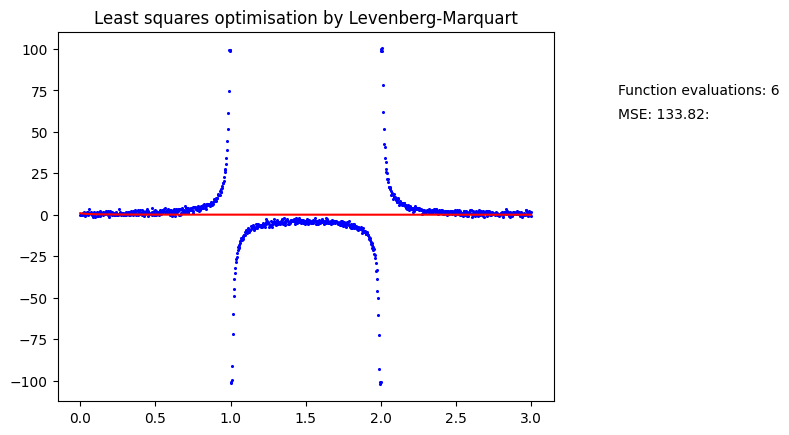

In [10]:
plot_results_fixed(lev_mar_res.x, 'Levenberg-Marquart', None, lev_mar_res.nfev, lev_mar_res.cost)

Converged quickly in just 6 function evaluations with an MSE of 133.82. The approximation differs from Nelder Mead but is more robust to function peak points.

### Simulated annealing

In [11]:
def simulated_annealing(func, bounds, max_iter=MAX_ITER, step_size=0.001, init_t=10):
    best = np.random.uniform(bounds[0], bounds[1], size=4)
    best_val = func(best)
    best_iter = 0

    curr, curr_val = best, best_val
    hist = [curr_val]
    for i in range(max_iter):
        candidate = curr + np.random.normal(0, 1, 4) * step_size
        candidate_val = func(candidate)
        hist.append(candidate_val)
        
        if candidate_val < best_val:
            best, best_val = candidate, candidate_val
            best_iter = i

        diff = candidate_val - curr_val
        t_ = init_t / float(i + 1)  
        if t_ < 1e-6:
            break
           
        metropolis = np.exp(-diff / t_)
        
        if diff < 0 or np.random.rand() < metropolis:
            curr, curr_val = candidate, candidate_val
    return best, best_val, best_iter, hist


In [12]:
ann_x, ann_func, ann_iter,  ann_hist = simulated_annealing(least_squares_fixed, bounds=[-2, 2], max_iter=1000)

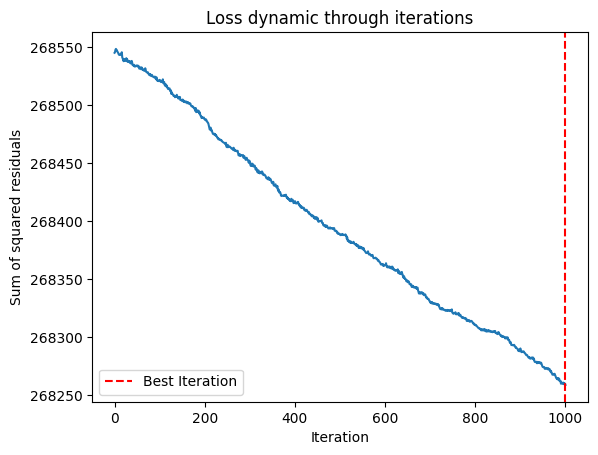

In [13]:
plt.title(f'Loss dynamic through iterations')
plt.xlabel('Iteration')
plt.ylabel('Sum of squared residuals')
plt.plot(ann_hist);

plt.axvline(x=ann_iter, color='red', linestyle='--', label='Best Iteration')

# Show a legend to indicate the meaning of the red line
plt.legend()

The loss monotonically decreases over iterations, but the best results were consistently achieved on the final iterations, specifically at 999 iterations. However, it's worth noting that this method exhibited significant instability.

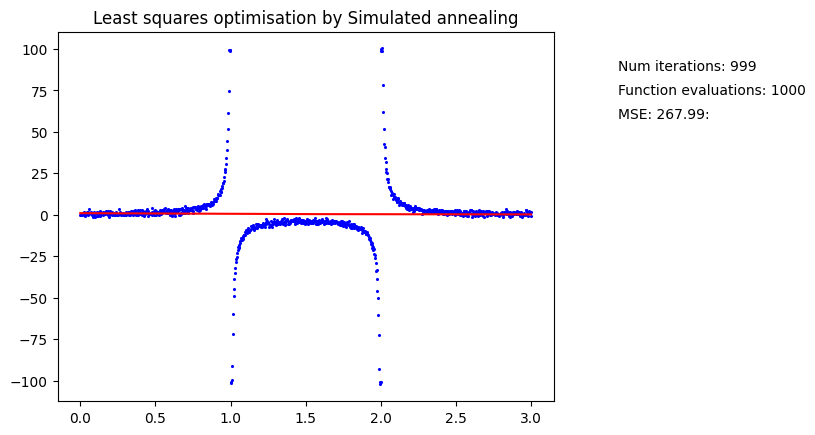

In [27]:
plot_results_fixed(ann_x, 'Simulated annealing', ann_iter, 1000, ann_func)

 We got result similar to Levenberg Marquardt but with a higher MSE = 268. 

### Differential evolution

In [15]:
dif_ev_res = differential_evolution(least_squares_fixed, [(-5,5)]*4, maxiter=MAX_ITER, tol=0.001)

In [16]:
dif_ev_res.x

array([-1.00618297,  1.00665696, -2.00093707,  1.00095343])

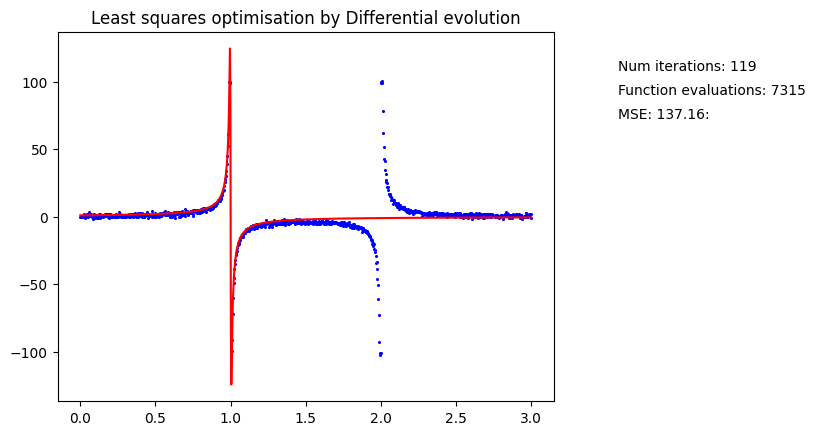

In [17]:
plot_results_fixed(dif_ev_res.x, 'Differential evolution', dif_ev_res.nit, dif_ev_res.nfev, dif_ev_res.fun)

The found approximation is similar to Nelder Mead but with a lower MSE of 137.16. The best result was obtained at 119 iterations, but it required many function evaluations (7315).

#### Methods comparision

In [18]:
methods = {
    'Nelder-Mead': nel_mead_res.x,
    'Levenberg-Marquart': lev_mar_res.x,
    'Simulated annealing': ann_x,
    'Differential_evolution': dif_ev_res.x
}

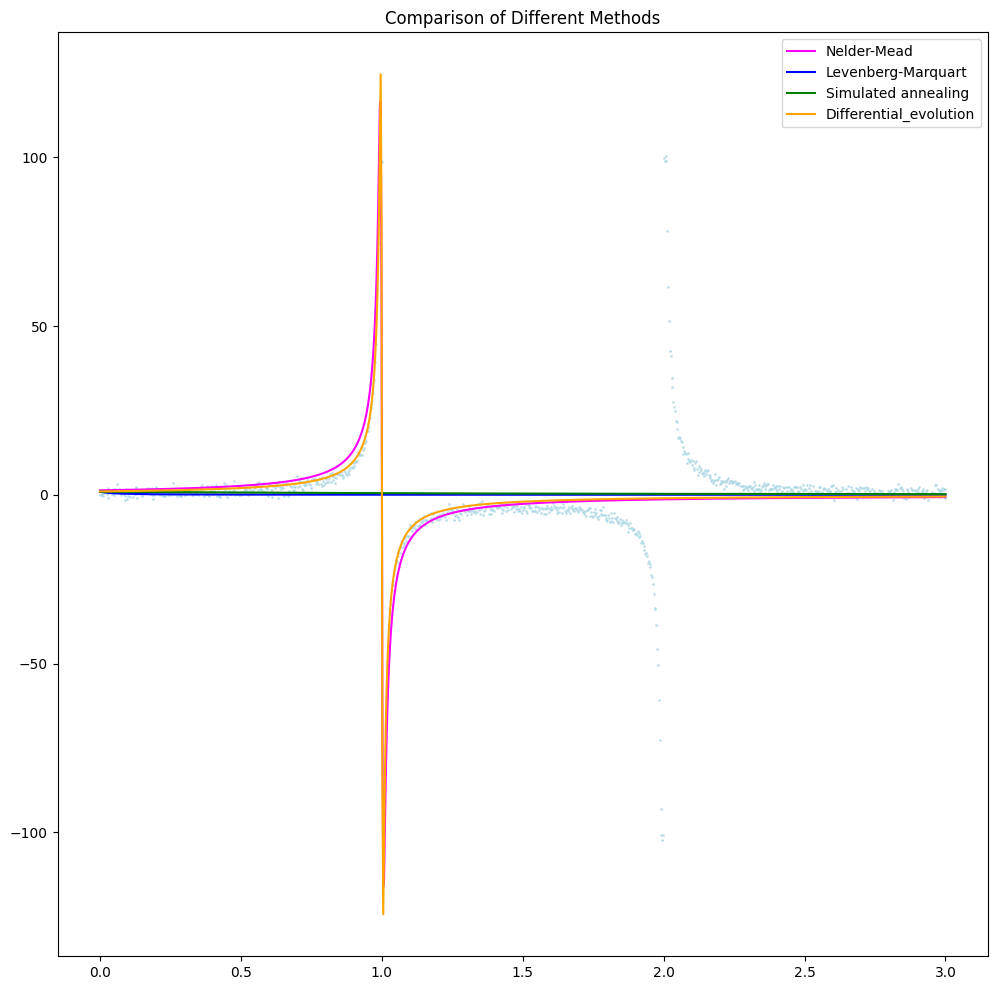

In [19]:
plot_comparision_fixed(methods)

Upon comparing all these methods, we observe that they yield relatively low Mean Squared Error (MSE) values, highlighting their effectiveness in approximating the target function. However, it's worth noting that Annealing, while providing reasonable results, demonstrates the highest MSE among the methods, making it the least favorable choice for this particular task.

## Part 2. Travelling salesman problem 

In [20]:
distances_matrix = np.array([[0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46], 
                             [29, 0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21], 
                             [82, 55, 0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51], 
                             [46, 46, 68, 0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64], 
                             [68, 42, 46, 82, 0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23], 
                             [52, 43, 55, 15, 74, 0, 61, 23, 55, 31, 33, 37, 51, 29, 59], 
                             [72, 43, 23, 72, 23, 61, 0, 42, 23, 31, 77, 37, 51, 46, 33], 
                             [42, 23, 43, 31, 52, 23, 42, 0, 33, 15, 37, 33, 33, 31, 37], 
                             [51, 23, 41, 62, 21, 55, 23, 33, 0, 29, 62, 46, 29, 51, 11], 
                             [55, 31, 29, 42, 46, 31, 31, 15, 29, 0, 51, 21, 41, 23, 37], 
                             [29, 41, 79, 21, 82, 33, 77, 37, 62, 51, 0, 65, 42, 59, 61], 
                             [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65, 0, 61, 11, 55], 
                             [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61, 0, 62, 23], 
                             [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62, 0, 59], 
                             [46, 21, 51, 64, 23, 59, 33, 37, 11, 37, 61, 55, 23, 59, 0]])

def get_candidate(path, methods=None):
    if methods is None:
        methods = ['swap', 'reverse', 'edge_swap']  # Add more methods as needed

    chosen_method = random.choice(methods)

    neighbor_path = path.copy()
    num_cities = len(path)
    
    if chosen_method == 'swap':
        # Swap two random cities
        i, j = random.sample(range(num_cities), 2)
        neighbor_path[i], neighbor_path[j] = neighbor_path[j], neighbor_path[i]
    
    elif chosen_method == 'reverse':
        # Reverse a random subsequence of cities
        i, j = sorted(random.sample(range(num_cities), 2))
        neighbor_path[i:j+1] = list(reversed(neighbor_path[i:j+1]))
    
    
    elif chosen_method == 'edge_swap':
        # Swap two random edges (pairs of cities)
        i, j, k, l = random.sample(range(num_cities), 4)
        neighbor_path[i], neighbor_path[j], neighbor_path[k], neighbor_path[l] = neighbor_path[k], neighbor_path[l], neighbor_path[i], neighbor_path[j]
    
    # Add more methods as needed

    return neighbor_path


def get_cost(path):
    cost = 0
    for ind in range(len(path)):
        start = path[ind]
        if ind == len(path) - 1:
            end = path[0]
        else:
            end = path[ind+1]
        cost += distances_matrix[start][end]
    return cost

def simulated_annealing_salesman(init_path, max_iter=MAX_ITER, init_t=10):
    best = init_path
    best_val = get_cost(best)
    best_iter = 0

    curr, curr_val = best, best_val
    history = [curr_val]
    for i in range(max_iter):
        candidate = get_candidate(curr)
        candidate_val = get_cost(candidate)
        history.append(candidate_val)

        if candidate_val < best_val:
            best, best_val = candidate, candidate_val
            best_iter = i

        diff = candidate_val - curr_val
        t_ = init_t / float(i + 1)  
        if t_ < 1e-6:
            break
           
        metropolis = np.exp(-diff / t_)
        
        if diff < 0 or np.random.rand() < metropolis:
            curr, curr_val = candidate, candidate_val

    return best, best_val, best_iter, history

In [21]:
init_path = np.random.choice(15, 15, replace=False)

In [22]:
ans, best_cost, best_iter, hist = simulated_annealing_salesman(init_path, max_iter=1000, init_t=5_000)

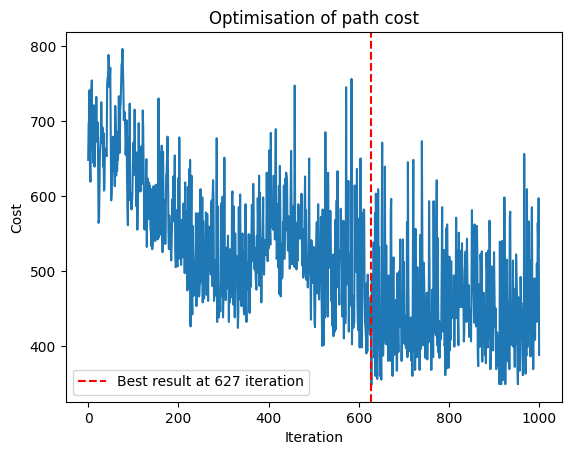

In [23]:
plt.title(f'Optimisation of path cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.plot(hist);

plt.axvline(x=best_iter, color='red', linestyle='--', label=f'Best result at {best_iter} iteration')

# Show a legend to indicate the meaning of the red line
plt.legend()

Optimization by annealing demonstrates a noisy decrease in cost through iterations. The best result was achieved on the 627th iteration.

In [24]:
def visualize_path(distance_matrix, path, title):
    # Create a graph
    G = nx.Graph()

    # Add nodes for cities
    num_cities = len(distance_matrix)
    G.add_nodes_from(range(num_cities))

    # Add edges with distances from the distance matrix
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            G.add_edge(i, j, weight=distance_matrix[i][j])

    # Create a list of edges in the order of the path
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    edges.append((path[-1], path[0]))  # Connect back to the starting city

    # Draw the graph with reduced alpha for edges not in the path (on the left side)
    pos = nx.spring_layout(G, seed=42)  # You can adjust the layout algorithm
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='red')
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, edge_color='b', alpha=0.5)  # Edges in the path (highlighted in blue)
    nx.draw_networkx_edges(G, pos, edgelist=list(set(G.edges()) - set(edges)), alpha=0.2)  # Other edges (less visible)

    plt.title(title)
    plt.figtext(.8, .8, f"Cost of path: {get_cost(path)}")  # Assuming you have a function get_cost(path)
    plt.axis('off')
    plt.show()


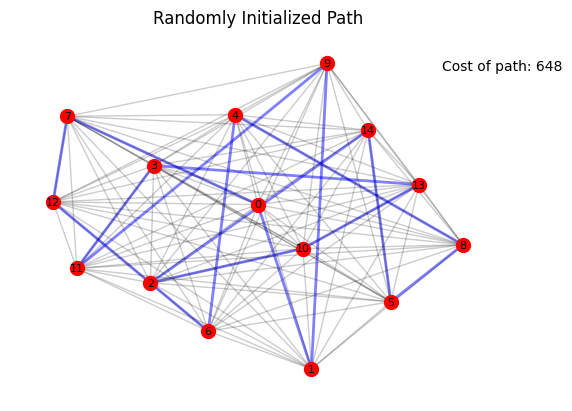

In [25]:
visualize_path(distances_matrix, init_path, 'Randomly Initialized Path')

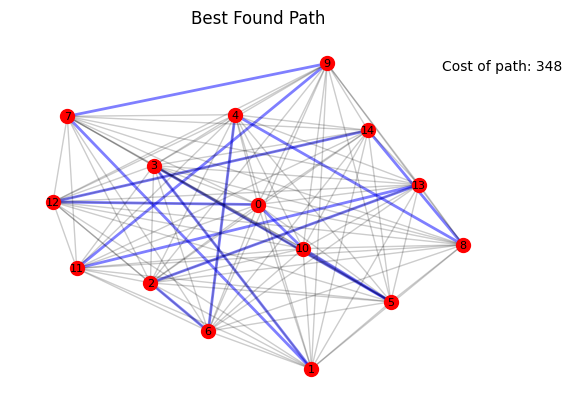

In [26]:
visualize_path(distances_matrix, ans, 'Best Found Path')

Here we can notice the effectiveness of simulated annealing in improving a given path. The best result was achieved at the 627th iteration, significantly reducing the path cost from the initial 648 to 348, showcasing the method's capability to enhance solutions for optimization problems like the Traveling Salesman Problem